<h3>Linear regression with Polynomial</h3>


#### Aims 

* Practice general linear regression with polynomial and RBF 
* Choose the order of polynomials with cross validation
* Practice ridge regression
* Implement cross-validation to choose the right polynoimal order
* Test polynoimal regression and cross-validation on new data where the true order is known
* Test ridge regression
* Test linear regression with the RBF

In [3]:
import numpy as np 
%matplotlib inline
import pylab as plt

data = np.loadtxt('olympic100m.txt', delimiter=',') # make sure olympic100m.txt is in the right folder
x = data[:,0][:,None] # make x a matrix
t = data[:,1][:,None] # make t a column vector 

print(x.shape)
print(t.shape)

(27, 1)
(27, 1)


#### Perform Polynomial Regression on the Olympic data

#### Rescale $x$ 
Rescale $x$ to make it small. Doing so will stablise the computation, otherwise it quickly becomes unfeasible to fit polynomials over ~$2000$. 

In [8]:
def transform(x):
    re_x = (x-np.mean(x))/np.std(x)
    return re_x

Text(0, 0.5, 'Time (seconds)')

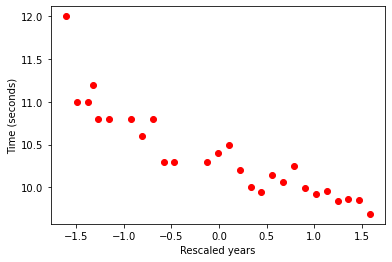

In [9]:
x = transform(x) # rescale x here
plt.plot(x, t, 'ro')
plt.xlabel('Rescaled years')
plt.ylabel('Time (seconds)')

#### construct the design matrix with polynomials

$$\mathbf{X} = \begin{bmatrix}
    1       & x_{1} & x_{1}^2 & \dots & x_{1}^K \\
    1       & x_{2} & x_{2} & \dots & x_{2}^K \\
    \vdots & \vdots &\vdots &\ddots &\vdots\\
    1       & x_{N} & x_{N}^2 & \dots & x_{N}^K
\end{bmatrix} $$

In [10]:
def make_polynomial(x, maxorder): 
    X = np.ones_like(x)
    for i in range(1,maxorder+1):
        X = np.hstack((X,x**i))
    return(X) 

#### Construct the design matrix with a predefined maximum polynomial order 

In [25]:
poly_order = 9
X_train = make_polynomial(x, poly_order) 

#### Fit a linear regression model with polynomial matrix and print out the training loss

In [26]:
from sklearn.linear_model import LinearRegression
poly_reg = LinearRegression().fit(X_train, t) # Fit a linear model
print('loss at order ', poly_order, ' :', np.mean((t - poly_reg.predict(X_train))**2 ) )

loss at order  9  : 31226.73409313173


#### Plot the fitted model and data

Text(0, 0.5, 'Time (seconds)')

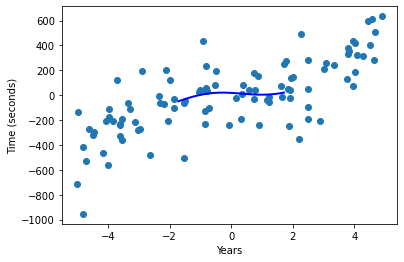

In [27]:
x_test = np.linspace(1880,2020, 100)[:,None] # test data
x_test = transform(x_test) # do the same rescaling to the test data 
X_test = make_polynomial(x_test, poly_order) # construct the polynomial matrix for test data
f_test = poly_reg.predict(X_test)
plt.plot(x_test,f_test,'b-',linewidth=2) # plot the fitted data
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('Years') # always label x&y-axis
plt.ylabel('Time (seconds)') # always label x&y-axis

### Choosing Polynomial order with Cross-Validation

#### Cross-Validation with a given Polynomial order.

In [34]:
from sklearn.model_selection import KFold 
cv = KFold(n_splits = 5) # call KFold to set up CV 
loss = [] # initiate a set to collect loss
reg =  LinearRegression() # call a linear regression model

poly_order = 9 
X_train = make_polynomial(x, poly_order)

for train_index, test_index in cv.split(X_train): 
    print('TRAIN:', train_index, 'TEST:', test_index)
    X_train_cv, X_test_cv = X_train[train_index], X_train[test_index] # select X for training and testing
    t_train_cv, t_test_cv = t[train_index], t[test_index] # select t for training and testing
    reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
    loss.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2 ) ) # compute loss on test data
print(loss) # print loss across fold
print(np.mean(loss)) # print average loss at this polynomial order

TRAIN: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] TEST: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 40 41 42 43
 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] TEST: [20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 60 61 62 63 64 65 66 67
 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91
 92 93 94 95 96 97 98 99] TEST: [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10

#### Cross-Validation for a range of Polynomial orders.

Text(0, 0.5, 'Log Loss')

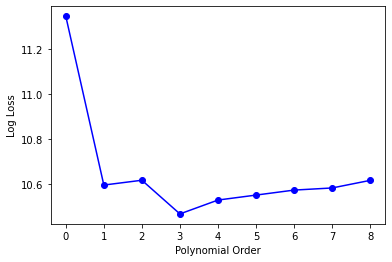

In [35]:
cv = KFold(n_splits = 10) # call KFold to set up CV 
reg = LinearRegression() # call a linear regression model
all_loss = [] # initiate a set to collect loss

for i in range(9):  # 1st for loop over polynomial orders 
    poly_order = i
    X_train = make_polynomial(x, poly_order) 
    loss_at_order = [] # initiate a set to collect loss for CV
    for train_index, test_index in cv.split(X_train): # 2nd for loop for cross-validation
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index] # select X for training and testing
        t_train_cv, t_test_cv = t[train_index], t[test_index] # select t for training and testing
        reg.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss_at_order.append( np.mean(( t_test_cv - reg.predict(X_test_cv) )**2 ) ) # collect loss at fold
    all_loss.append(np.mean(loss_at_order)) # collect loss at order
plt.plot(np.log(all_loss), 'bo-') # plot log(loss) at order
plt.xlabel('Polynomial Order') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis

### Cross-Validation for Polynomial order on new data

In [36]:
np.random.seed(1) # fix random seed such that every time get the same random numbers

N = 100 # total number of data points 
x = 10*np.random.rand(N,1) - 5 # generate random x
t = 5*x**3 - x**2 + x + 200*np.random.randn(N,1) # generate t according to the true model with additive noise

N_independent_test = 50 # total number of independent testing data points 
x_independent_test = 10*np.random.rand(N_independent_test,1) - 5 # generate independent testing x
t_independent_test = 5*x_independent_test**3 - x_independent_test**2 + x_independent_test + 200*np.random.randn(N_independent_test,1) # generate independent testing t with noise

### Plot new data.

Text(0, 0.5, 't')

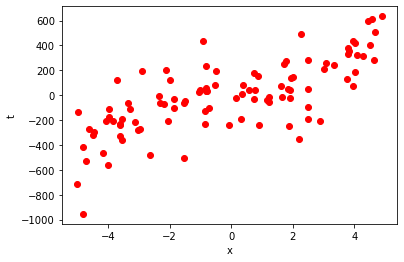

In [37]:
plt.plot(x, t, 'ro')
plt.xlabel('x')
plt.ylabel('t')

#### Redo Cross-Validation for Polynomial order on new data. Plot CV loss, training loss, and loss on the independent test set

Text(0, 0.5, 'Log Loss')

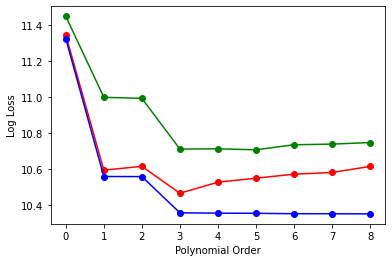

In [38]:
cv = KFold(n_splits = 10)
reg = LinearRegression() # model for CV
reg_train = LinearRegression() # model for loss on training and independent test 

all_loss = []
all_loss_trian = []
all_loss_independent_test = []

for i in range(9):  # 1st for loop over polynomial order
    
    poly_order = i
   
    X_train = make_polynomial(x, poly_order) # construct polynomial matrix for all training data
    #poly_reg = reg.fit(X_train, t) # fit model on all training data
    reg_train.fit(X_train, t)
    all_loss_trian.append( np.mean( (t - reg_train.predict(X_train))**2 ) ) # collect training loss
    
    X_test = make_polynomial(x_independent_test, poly_order) #construct polynomial matrix for the independent test data
    
    all_loss_independent_test.append(
        np.mean( (t_independent_test - reg_train.predict(X_test))**2 ) ) # collect loss on independent test data
    
    loss_at_order = [] 
    for train_index, test_index in cv.split(X_train): # 2nd for loop over folds
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index] # select X for training and testing
        t_train_cv, t_test_cv = t[train_index], t[test_index] # select t for training and testing
        reg_train.fit(X_train_cv, t_train_cv) # fit a model on the training data 
        loss_at_order.append( np.mean(( t_test_cv - reg_train.predict(X_test_cv) )**2 ) ) # collect loss at fold
    all_loss.append(np.mean(loss_at_order)) # collect loss at order

plt.plot(np.log(all_loss), 'ro-') 
plt.plot(np.log(all_loss_trian), 'bo-')
plt.plot(np.log(all_loss_independent_test), 'go-')
plt.xlabel('Polynomial Order') # always label x&y-axis
plt.ylabel('Log Loss') # always label x&y-axis

### Polynomial Linear Regression with L2 regression.

$$ \hat{\mathbf{w}}_{ridge} = \underset{\mathbf{w} }{\mathrm{argmin}}
 \frac{1}{N} (\mathbf{t} - \mathbf{X}\mathbf{w} )^{T} (\mathbf{t} - \mathbf{X}\mathbf{w} ) + \alpha \mathbf{w}^T \mathbf{w}$$
check out https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html for `Ridge`
check out https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html for `GridSearchCV`

Text(0, 0.5, 'Time (seconds)')

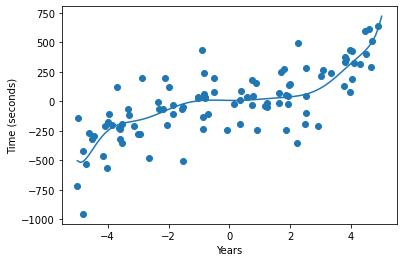

In [40]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

poly_order = 10
X_train = make_polynomial(x, poly_order) # construct polynomial matrix on training data

x_test = np.linspace(-5,5, 100)[:,None] # generate x_test for plotting
X_test = make_polynomial(x_test, poly_order) # construct polynomial matrix on x_test

ridge = Ridge() # call ridge model
parameters = {'alpha': np.linspace(1, 10, 20)} # set out search grid for alpha
ridge_model = GridSearchCV(ridge, parameters, scoring = 'neg_mean_squared_error', cv=5) # Define CV on the search grid to define alpha
ridge_model.fit(X_train, t) # Fit training data

plt.plot(x_test, ridge_model.predict(X_test)) # plot the model
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('Years') # always label x&y-axis
plt.ylabel('Time (seconds)') # always label x&y-axis

### Practice linear regression with RBF. 

Write you own function to construct the design matrix with RBF

$$ h_k(x) = \exp \left( -\frac{ (x-\mbox{center}[k]) ^2}{2\mbox{width}}  \right)$$

In [41]:
def make_rbf(x, center, width):  # again np.hstack is very helpful
    #X = np.exp( -( (x - np.mean(center, axis=1) )**2  / (2 * width) ) )
    X = np.exp ( -0.5 * (x-center[0])**2/width )  
    for i in range (len(center))[1:]:
        X = np.hstack( (X,np.exp( -0.5 * (x-center[i])**2/width )) )
    return(X)

#### Construct  the design matrix with $x$ itself as the center parameter
Start with `width = 10` and test different values

In [42]:
center = x 
width = 10
X_rbf = make_rbf(x, center, width)
X_rbf.shape

(100, 100)

#### Fit a linear regression model with X constructed by RBF

Text(0, 0.5, 'x')

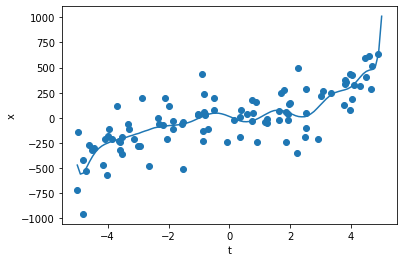

In [43]:

x_test = np.linspace(5,-5,100)[:,None]
#print( x_test.shape)
X_test = make_rbf(x_test, center, width)
#print( X_test.shape)

reg = LinearRegression()
reg.fit(X_rbf, t)

plt.plot(x_test, reg.predict(X_test))
plt.scatter(x,t) # draw a scatter plot
plt.xlabel('t') # always label x&y-axis
plt.ylabel('x') # always label x&y-axis